# **Econ 441B 23Winter Lec7**
## **Juntao Li 906092273**


# 1.) Import an asset price from Yahoo Finance

In [2]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 14.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("NVAX", start="1997-01-01", end="2022-02-21")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


In [10]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-01-02,67.500000,68.750000,66.250000,67.500000,67.500000,1030
1997-01-03,66.250000,71.250000,66.250000,71.250000,71.250000,600
1997-01-06,71.250000,71.250000,67.500000,67.500000,67.500000,450
1997-01-07,65.000000,66.250000,62.500000,66.250000,66.250000,905
1997-01-08,67.500000,67.500000,65.000000,67.500000,67.500000,830
...,...,...,...,...,...,...
2022-02-14,86.910004,88.699997,79.989998,80.110001,80.110001,5065500
2022-02-15,81.570000,88.879997,80.800003,87.129997,87.129997,4448700
2022-02-16,85.580002,86.970001,82.830002,86.550003,86.550003,3069700


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [68]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25,activation="relu"))
model.add(Dense(32,activation="sigmoid"))




model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
5055/5055 [==============================] - 24s 4ms/step - loss: 0.0052
Epoch 2/3
5055/5055 [==============================] - 21s 4ms/step - loss: 0.0031
Epoch 3/3
5055/5055 [==============================] - 22s 4ms/step - loss: 0.0031


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [64]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))





In [75]:
y_train_reshaped=y_train.reshape(5055,1)
y_train_reshaped.shape

(5055, 1)

In [80]:
#Random Walk
in_sample_rw_y_true=y_train[1:] #Actual
in_sample_rw_y_pred=y_train[:-1] #Prediction

#Random Walk
out_of_sample_rw_y_true=y_test[1:] #Actual
out_of_sample_rw_y_pred=y_test[:-1] #Prediction

In [82]:
#In-sample RW RMSE
in_sample_rw_rmse=np.sqrt(np.mean(in_sample_rw_y_pred-in_sample_rw_y_true)**2)
print('In sample RW RMSE:',in_sample_rw_rmse)

In sample RW RMSE: 1.6477156118887757e-05


In [83]:
#Out-of-sample RW RMSE
out_of_sample_rw_rmse=np.sqrt(np.mean(out_of_sample_rw_y_pred-out_of_sample_rw_y_true)**2)
print('Out of sample RW RMSE:',out_of_sample_rw_rmse)

Out of sample RW RMSE: 2.666226038487651e-05


In [78]:
#In-sample RMSE
y_train_pred=model.predict(x_train)
in_sample_rmse=np.sqrt(np.mean(y_train_pred-y_train_reshaped)**2)
print('In sample RMSE:',in_sample_rmse)

158/158 [==============================] - 0s 2ms/step
In sample RMSE: 0.0012676201172117255


In [79]:
#Out-of-sample RMSE
y_test_pred=model.predict(x_test)
out_of_sample_rmse=np.sqrt(np.mean(y_test_pred-y_test)**2)
print('Out of sample RMSE:',out_of_sample_rmse)

40/40 [==============================] - 0s 3ms/step
Out of sample RMSE: 0.003581923611819438


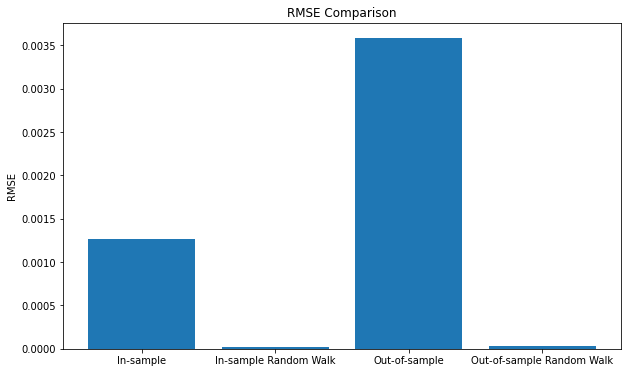

In [88]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
rmse = [in_sample_rmse, in_sample_rw_rmse,
              out_of_sample_rmse, out_of_sample_rw_rmse]
labels = ['In-sample', 'In-sample Random Walk', 'Out-of-sample', 'Out-of-sample Random Walk']

plt.bar(labels, rmse)
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

From the bar plot from question 3, we can see that the RMSE of random walk data is very small compared to the RMSE of non-random-walk data. In addition, the RMSE of in-sample data is also smaller than that of out-of-sample data.